### Tarsnformer Encoder Model
> KU-HAR dataset | __action set without [stand, sit. lay]__

In [1]:
import logging

logging.basicConfig(format='%(asctime)s | %(levelname)s : %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)
logger.info("Loading packages ...")

import os
import sys
import time
import pickle
import json
from argparse import Namespace

# 3rd party packages
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

# Project modules
from src.options import Options
from src.running import setup, pipeline_factory, validate, check_progress, NEG_METRICS
from src.utils import utils
from src.datasets.data import data_factory, Normalizer
from src.datasets.datasplit import split_dataset
from src.models.ts_transformer import model_factory
from src.models.loss import get_loss_module
from src.optimizers import get_optimizer

import neptune.new as neptune

2022-09-23 15:12:06,860 | INFO : Loading packages ...


The Zen of Python, by Tim Peters

Beautiful is better than ugly.
Explicit is better than implicit.
Simple is better than complex.
Complex is better than complicated.
Flat is better than nested.
Sparse is better than dense.
Readability counts.
Special cases aren't special enough to break the rules.
Although practicality beats purity.
Errors should never pass silently.
Unless explicitly silenced.
In the face of ambiguity, refuse the temptation to guess.
There should be one-- and preferably only one --obvious way to do it.
Although that way may not be obvious at first unless you're Dutch.
Now is better than never.
Although never is often better than *right* now.
If the implementation is hard to explain, it's a bad idea.
If the implementation is easy to explain, it may be a good idea.
Namespaces are one honking great idea -- let's do more of those!


In [2]:
run = neptune.init(
    project="FYP-Group22/Transformer-SSC",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkNWJjMDdhNC05NWY5LTQwNWQtYTQyNi0zNjNmYmYwZDg3M2YifQ==",
)  # your credentials

https://app.neptune.ai/FYP-Group22/Transformer-SSC/e/TRAN-31
Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api-reference/run#.stop). It will be stopped automatically only when the notebook kernel/interactive console is terminated.


In [3]:
config = {}
config["output_dir"] = './tmp'
config["seed"] = 123
config["gpu"] = "0" # activate gpu > o, on cpu > -1
config["n_proc"] = 1

# loading pre-trained model
config["load_model"] = None
config["test_only"] = None
config["config_filepath"] = None

# experiment config
config["task"] = "classification"
config["experiment_name"] = "first_test"
config["no_timestamp"] = True

# dataset settings
config["limit_size"] = 300 
config["data_class"] = 'kuhar'
config["data_dir"] = '../../Data/KU-HAR_time_domain_subsamples_20750x300.csv'
config["val_ratio"] = 0.1 
config["test_ratio"] = 0.1 
config["norm_from"] = False 
config["normalization"] = None #'standardization'
config["record_file"] = "./tmp/Imputation_records.xls"
config["records_file"] = "./tmp/records.xls"
config["num_workers"] = 0
config["console"] = True
config["save_all"] = False
config["comment"] = "mvts_transformer updated encoder flow | KU-HAR dataset Dynamic Actions | nipdep 1DConv processing layer | first test"

# test, val from seperate files 
config["test_pattern"] = False 
config["val_pattern"] = False 
config["test_from"] = False

# freeze model weight for fine-tunning
config["freeze"] = False

# if task is a imputation 
config["masking_ratio"] = 0.15
config["mean_mask_length"] = 5
config["mask_mode"] = "seperate"
config["mask_distribution"] = "geometric"
config["exclude_feats"] = None 
config["mask_feats"] = '0, 1'
config["start_hint"] = 0.0
config["end_hint"] = 0.0 
config["harden"] = True

# model parameters
config['model'] = 'transformer'
config["pos_encoding"] = "learnable"
config["d_model"] = 128 
config["dim_feedforward"] = 256
config["num_heads"] = 8
config["num_layers"] = 3
config["dropout"] = 0.1
config["activation"] = 'relu'
config["normalization_layer"] = "BatchNorm"
config["data_window_len"] = None 
config["max_seq_len"] = 300

# model training parameters
config["epochs"] = 10
config["lr"] = 0.0005
config["val_interval"] = 1
config["lr_step"] = '1000'
config["lr_factor"] = '0.1'
config["l2_reg"] = 0
config["global_reg"] = True
config["key_metric"] = "loss"
config["optimizer"] = "Adam"
config["batch_size"] = 32
config["print_interval"] = 1

setup(config)

2022-09-23 15:12:17,531 | INFO : Stored configuration file in './tmp\first_test'


{'output_dir': './tmp\\first_test',
 'seed': 123,
 'gpu': '0',
 'n_proc': 1,
 'load_model': None,
 'test_only': None,
 'config_filepath': None,
 'task': 'classification',
 'experiment_name': 'first_test',
 'no_timestamp': True,
 'limit_size': 300,
 'data_class': 'kuhar',
 'data_dir': '../../Data/KU-HAR_time_domain_subsamples_20750x300.csv',
 'val_ratio': 0.1,
 'test_ratio': 0.1,
 'norm_from': False,
 'normalization': None,
 'record_file': './tmp/Imputation_records.xls',
 'records_file': './tmp/records.xls',
 'num_workers': 0,
 'console': True,
 'save_all': False,
 'comment': 'mvts_transformer updated encoder flow | KU-HAR dataset Dynamic Actions | nipdep 1DConv processing layer | first test',
 'test_pattern': False,
 'val_pattern': False,
 'test_from': False,
 'freeze': False,
 'masking_ratio': 0.15,
 'mean_mask_length': 5,
 'mask_mode': 'seperate',
 'mask_distribution': 'geometric',
 'exclude_feats': None,
 'mask_feats': '0, 1',
 'start_hint': 0.0,
 'end_hint': 0.0,
 'harden': True,
 

In [4]:
run["parameters"] = config
config['class_names'] = ['Talk-sit', 'Talk-stand', 'Stand-sit', 'Lay-stand', 'Pick', 'Jump', 'Push-up', 'Sit-up', 'Walk', 'Walk-backward', 'Walk-circle', 'Run', 'Stair-up', 'Stair-down', 'Table-tennis']
# config['class_names'] = ['Stand', 'Sit', 'Talk-sit', 'Talk-stand', 'Stand-sit', 'Lay', 'Lay-stand', 'Pick', 'Jump', 'Push-up', 'Sit-up', 'Walk', 'Walk-backward', 'Walk-circle', 'Run', 'Stair-up', 'Stair-down', 'Table-tennis']

In [5]:
total_epoch_time = 0
total_eval_time = 0

total_start_time = time.time()

# Add file logging besides stdout
file_handler = logging.FileHandler(os.path.join(config['output_dir'], 'output.log'))
logger.addHandler(file_handler)

logger.info('Running:\n{}\n'.format(' '.join(sys.argv)))  # command used to run

if config['seed'] is not None:
    torch.manual_seed(config['seed'])

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info("Using device: {}".format(device))
if device == 'cuda':
    logger.info("Device index: {}".format(torch.cuda.current_device()))

2022-09-23 15:12:17,912 | INFO : Running:
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\ipykernel_launcher.py --ip=127.0.0.1 --stdin=9018 --control=9016 --hb=9015 --Session.signature_scheme="hmac-sha256" --Session.key=b"6c7a52bf-ad63-4f49-9bf5-e473580e0da0" --shell=9017 --transport="tcp" --iopub=9019 --f=c:\Users\deela\AppData\Roaming\jupyter\runtime\kernel-v2-5900JJjaEHkERqPZ.json

2022-09-23 15:12:17,967 | INFO : Using device: cuda


In [6]:
# Build data
logger.info("Loading and preprocessing data ...")
data_class = data_factory[config['data_class']]
my_data = data_class(config['data_dir'], n_proc=config['n_proc'], limit_size=config['limit_size'], config=config, filter_classes=[0, 1, 5])
feat_dim = my_data.feature_df.shape[1]  # dimensionality of data features
if config['task'] == 'classification':
    validation_method = 'StratifiedShuffleSplit'
    labels = my_data.labels_df.label.values
    print(labels)
else:
    validation_method = 'ShuffleSplit'
    labels = None

2022-09-23 15:12:18,078 | INFO : Loading and preprocessing data ...


[0 0 0 ... 6 6 6]


In [7]:
import numpy as np
np.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14],
      dtype=int64)

In [8]:
# Split dataset
test_data = my_data
test_indices = None  # will be converted to empty list in `split_dataset`, if also test_set_ratio == 0
val_data = my_data
val_indices = []
if config['test_pattern']:  # used if test data come from different files / file patterns
    test_data = data_class(config['data_dir'], n_proc=-1, config=config)
    test_indices = test_data.all_IDs
if config['test_from']:  # load test IDs directly from file, if available, otherwise use `test_set_ratio`. Can work together with `test_pattern`
    test_indices = list(set([line.rstrip() for line in open(config['test_from']).readlines()]))
    try:
        test_indices = [int(ind) for ind in test_indices]  # integer indices
    except ValueError:
        pass  # in case indices are non-integers
    logger.info("Loaded {} test IDs from file: '{}'".format(len(test_indices), config['test_from']))
if config['val_pattern']:  # used if val data come from different files / file patterns
    val_data = data_class(config['data_dir'], n_proc=-1, config=config)
    val_indices = val_data.all_IDs

# Note: currently a validation set must exist, either with `val_pattern` or `val_ratio`
# Using a `val_pattern` means that `val_ratio` == 0 and `test_ratio` == 0
if config['val_ratio'] > 0:
    train_indices, val_indices, test_indices = split_dataset(data_indices=my_data.all_IDs,
                                                                validation_method=validation_method,
                                                                n_splits=1,
                                                                validation_ratio=config['val_ratio'],
                                                                test_set_ratio=config['test_ratio'],  # used only if test_indices not explicitly specified
                                                                test_indices=test_indices,
                                                                random_seed=1337,
                                                                labels=labels)
    train_indices = train_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
    val_indices = val_indices[0]  # `split_dataset` returns a list of indices *per fold/split*
else:
    train_indices = my_data.all_IDs
    if test_indices is None:
        test_indices = []

logger.info("{} samples may be used for training".format(len(train_indices)))
logger.info("{} samples will be used for validation".format(len(val_indices)))
logger.info("{} samples will be used for testing".format(len(test_indices)))

with open(os.path.join(config['output_dir'], 'data_indices.json'), 'w') as f:
    try:
        json.dump({'train_indices': list(map(int, train_indices)),
                    'val_indices': list(map(int, val_indices)),
                    'test_indices': list(map(int, test_indices))}, f, indent=4)
    except ValueError:  # in case indices are non-integers
        json.dump({'train_indices': list(train_indices),
                    'val_indices': list(val_indices),
                    'test_indices': list(test_indices)}, f, indent=4)

2022-09-23 15:13:28,180 | INFO : 12293 samples may be used for training
2022-09-23 15:13:28,182 | INFO : 1366 samples will be used for validation
2022-09-23 15:13:28,184 | INFO : 1518 samples will be used for testing


In [9]:
# Pre-process features
normalizer = None
if config['norm_from']:
    with open(config['norm_from'], 'rb') as f:
        norm_dict = pickle.load(f)
    normalizer = Normalizer(**norm_dict)
elif config['normalization'] is not None:
    normalizer = Normalizer(config['normalization'])
    my_data.feature_df.loc[train_indices] = normalizer.normalize(my_data.feature_df.loc[train_indices])
    if not config['normalization'].startswith('per_sample'):
        # get normalizing values from training set and store for future use
        norm_dict = normalizer.__dict__
        with open(os.path.join(config['output_dir'], 'normalization.pickle'), 'wb') as f:
            pickle.dump(norm_dict, f, pickle.HIGHEST_PROTOCOL)
if normalizer is not None:
    if len(val_indices):
        print("Validation dataset normalization")
        val_data.feature_df.loc[val_indices] = normalizer.normalize(val_data.feature_df.loc[val_indices])
    if len(test_indices):
        print("Test dataset normalization")
        test_data.feature_df.loc[test_indices] = normalizer.normalize(test_data.feature_df.loc[test_indices])

In [10]:
# Create model
logger.info("Creating model ...")
model = model_factory(config, my_data)

if config['freeze']:
    for name, param in model.named_parameters():
        if name.startswith('output_layer'):
            param.requires_grad = True
        else:
            param.requires_grad = False

logger.info("Model:\n{}".format(model))
logger.info("Total number of parameters: {}".format(utils.count_parameters(model)))
logger.info("Trainable parameters: {}".format(utils.count_parameters(model, trainable=True)))


2022-09-23 15:13:28,310 | INFO : Creating model ...
2022-09-23 15:13:28,326 | INFO : Model:
TSTransformerEncoderClassiregressor(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
      

In [11]:
# Initialize optimizer

if config['global_reg']:
    weight_decay = config['l2_reg']
    output_reg = None
else:
    weight_decay = 0
    output_reg = config['l2_reg']

optim_class = get_optimizer(config['optimizer'])
optimizer = optim_class(model.parameters(), lr=config['lr'], weight_decay=weight_decay)

start_epoch = 0
lr_step = 0  # current step index of `lr_step`
lr = config['lr']  # current learning step
# Load model and optimizer state
if config["load_model"]:
    model, optimizer, start_epoch = utils.load_model(model, config['load_model'], optimizer, config['resume'],
                                                        config['change_output'],
                                                        config['lr'],
                                                        config['lr_step'],
                                                        config['lr_factor'])
model.to(device)

loss_module = get_loss_module(config)

if config['test_only'] == 'testset':  # Only evaluate and skip training
    dataset_class, collate_fn, runner_class = pipeline_factory(config)
    test_dataset = dataset_class(test_data, test_indices)

    test_loader = DataLoader(dataset=test_dataset,
                                batch_size=config['batch_size'],
                                shuffle=False,
                                num_workers=config['num_workers'],
                                pin_memory=True,
                                collate_fn=lambda x: collate_fn(x, max_len=model.max_len))
    test_evaluator = runner_class(model, test_loader, device, loss_module,
                                        print_interval=config['print_interval'], console=config['console'])
    aggr_metrics_test, per_batch_test = test_evaluator.evaluate(keep_all=True)
    print_str = 'Test Summary: '
    for k, v in aggr_metrics_test.items():
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    # return

In [12]:
# Initialize data generators
dataset_class, collate_fn, runner_class = pipeline_factory(config)
val_dataset = dataset_class(val_data, val_indices)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=config['batch_size'],
                        shuffle=False,
                        num_workers=config['num_workers'],
                        pin_memory=True,
                        collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

train_dataset = dataset_class(my_data, train_indices)

train_loader = DataLoader(dataset=train_dataset,
                            batch_size=config['batch_size'],
                            shuffle=True,
                            num_workers=config['num_workers'],
                            pin_memory=True,
                            collate_fn=lambda x: collate_fn(x, max_len=model.max_len))

trainer = runner_class(model, train_loader, device, loss_module, optimizer, l2_reg=output_reg,
                                print_interval=config['print_interval'], console=config['console'])
val_evaluator = runner_class(model, val_loader, device, loss_module,
                                    print_interval=config['print_interval'], console=config['console'])

tensorboard_writer = SummaryWriter(config['tensorboard_dir'])

best_value = 1e16 if config['key_metric'] in NEG_METRICS else -1e16  # initialize with +inf or -inf depending on key metric
metrics = []  # (for validation) list of lists: for each epoch, stores metrics like loss, ...
best_metrics = {}

In [13]:
# for i in train_loader:
#     print(i)
#     break

2022-09-23 15:13:34,760 | INFO : Evaluating on validation set ...


Evaluating Epoch 0  97.7% | batch:        42 of        43	|	loss: 2.71339

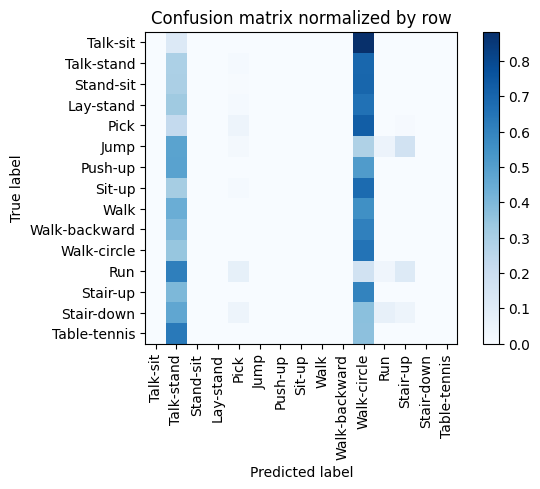

Overall accuracy: 0.052

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.000      0.000      0.000      0.143        196|	 Walk-circle: 0.699,	Talk-stand: 0.296,	Pick: 0.005,	
   Talk-stand       0.107      0.292      0.157      0.123        168|	 Walk-circle: 0.696,	Pick: 0.012,	
     Talk-sit       0.000      0.000      0.000      0.119        162|	 Walk-circle: 0.883,	Talk-stand: 0.117,	Table-tennis: 0.000,	
    Lay-stand       0.000      0.000      0.000      0.116        159|	 Walk-circle: 0.660,	Talk-stand: 0.327,	Pick: 0.013,	
         Pick       0.263      0.042      0.072      0.088        120|	 Walk-circle: 0.725,	Talk-stand: 0.225,	
       Sit-up       0.000      0.000      0.000      0.067         91|	 Walk-circle: 0.681,	Talk-stand: 0.308,	Pick: 0.011,	
         Walk       0.000      0.000      0.000      0.058         79|	 Walk-circle: 0.557,	Talk-stand: 0.443,	Table-tennis: 0.000,	
     Stair-up       0.000  

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 15:13:42,598 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 7.837080717086792 seconds

2022-09-23 15:13:42,599 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 7.837080717086792 seconds
2022-09-23 15:13:42,599 | INFO : Avg batch val. time: 0.18225769109504167 seconds
2022-09-23 15:13:42,600 | INFO : Avg sample val. time: 0.005737247962728252 seconds
2022-09-23 15:13:42,602 | INFO : Epoch 0 Validation Summary: epoch: 0.000000 | loss: 0.086423 | accuracy: 0.051977 | precision: 0.139026 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w




Distribution of classes with respect to PRECISION: 
[0.0, 0.2): 13
[0.2, 0.4): 2
[0.4, 0.6): 0
[0.6, 0.7): 0
[0.7, 0.8): 0
[0.8, 0.9): 0
[0.9, 1.0): 0
[1.0, 1.1): 0


Distribution of classes with respect to RECALL: 
[0.0, 0.2): 13
[0.2, 0.4): 1
[0.4, 0.6): 0
[0.6, 0.7): 1
[0.7, 0.8): 0
[0.8, 0.9): 0
[0.9, 1.0): 0
[1.0, 1.1): 0



Training Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

Training Epoch 1  99.7% | batch:       384 of       385	|	loss: 1.493627

2022-09-23 15:16:08,443 | INFO : Epoch 1 Training Summary: epoch: 1.000000 | loss: 0.051991 | 
2022-09-23 15:16:08,445 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 25.750746250152588 seconds

2022-09-23 15:16:08,446 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 25.750746250152588 seconds
2022-09-23 15:16:08,447 | INFO : Avg batch train. time: 0.37857336688351323 seconds
2022-09-23 15:16:08,448 | INFO : Avg sample train. time: 0.011856401712369038 seconds
2022-09-23 15:16:08,449 | INFO : Evaluating on validation set ...


Evaluating Epoch 1  97.7% | batch:        42 of        43	|	loss: 0.996332

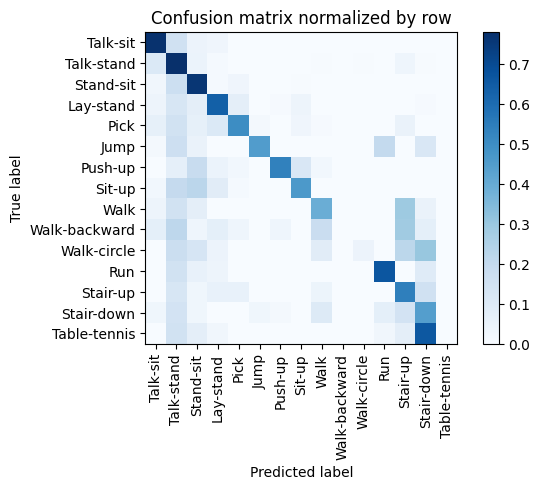

c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
2022-09-23 15:16:13,551 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.099578857421875 seconds

2022-09-23 15:16:13,552 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.4683297872543335 seconds
2022-09-23 15:16:13,552 | INFO : Avg batch val. time: 0.1504262741221938 seconds
2022-09-23 15:16:13,553 | INFO : Avg sample val. time: 0.004735234104871401 seconds
2022-09-23 15:16:13,557 | INFO : Epoch 1 Validation Summary: epoch: 1.000000 | loss: 0.039201 | accuracy: 0.582723 | precision: 0.625845 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (w

Overall accuracy: 0.583

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.634      0.760      0.691      0.143        196|	 Talk-stand: 0.168,	Pick: 0.031,	
   Talk-stand       0.419      0.780      0.545      0.123        168|	 Talk-sit: 0.107,	Stand-sit: 0.048,	
     Talk-sit       0.727      0.772      0.749      0.119        162|	 Talk-stand: 0.154,	Stand-sit: 0.043,	
    Lay-stand       0.706      0.635      0.669      0.116        159|	 Talk-stand: 0.126,	Pick: 0.075,	
         Pick       0.706      0.500      0.585      0.088        120|	 Talk-stand: 0.150,	Lay-stand: 0.108,	
       Sit-up       0.724      0.462      0.564      0.067         91|	 Stand-sit: 0.220,	Talk-stand: 0.198,	
         Walk       0.608      0.392      0.477      0.058         79|	 Stair-up: 0.291,	Talk-stand: 0.152,	
     Stair-up       0.390      0.542      0.453      0.053         72|	 Stair-down: 0.153,	Talk-stand: 0.125,	
   Stair-down     

2022-09-23 15:18:52,331 | INFO : Epoch 2 Training Summary: epoch: 2.000000 | loss: 0.036020 | 
2022-09-23 15:18:52,334 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 38.7399787902832 seconds

2022-09-23 15:18:52,336 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 32.245362520217896 seconds
2022-09-23 15:18:52,338 | INFO : Avg batch train. time: 0.395442500052514 seconds
2022-09-23 15:18:52,339 | INFO : Avg sample train. time: 0.012384719964224997 seconds
2022-09-23 15:18:52,340 | INFO : Evaluating on validation set ...


Evaluating Epoch 2  97.7% | batch:        42 of        43	|	loss: 0.938777

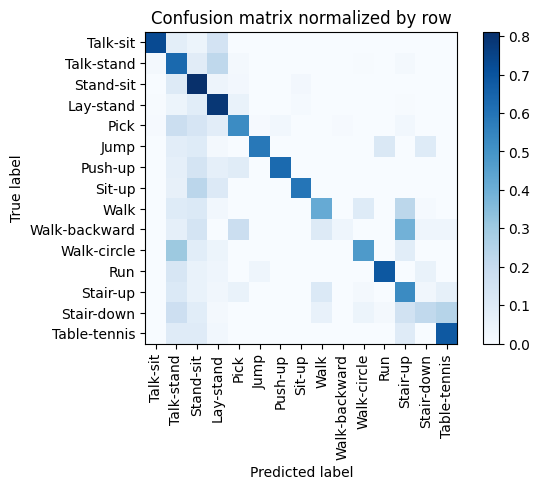

2022-09-23 15:18:58,048 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.707022666931152 seconds

2022-09-23 15:18:58,050 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.2145607471466064 seconds
2022-09-23 15:18:58,052 | INFO : Avg batch val. time: 0.14452466853829318 seconds
2022-09-23 15:18:58,054 | INFO : Avg sample val. time: 0.004549458819287413 seconds
2022-09-23 15:18:58,059 | INFO : Epoch 2 Validation Summary: epoch: 2.000000 | loss: 0.034742 | accuracy: 0.622255 | precision: 0.662036 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  20%|██        | 2/10 [05:15<21:11, 158.90s/it]

Overall accuracy: 0.622

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.576      0.811      0.674      0.143        196|	 Talk-stand: 0.107,	Lay-stand: 0.041,	
   Talk-stand       0.459      0.631      0.531      0.123        168|	 Lay-stand: 0.220,	Stand-sit: 0.089,	
     Talk-sit       0.959      0.728      0.828      0.119        162|	 Lay-stand: 0.148,	Talk-stand: 0.080,	
    Lay-stand       0.551      0.786      0.648      0.116        159|	 Stand-sit: 0.088,	Pick: 0.057,	
         Pick       0.685      0.525      0.594      0.088        120|	 Talk-stand: 0.183,	Stand-sit: 0.133,	
       Sit-up       0.900      0.593      0.715      0.067         91|	 Stand-sit: 0.231,	Lay-stand: 0.110,	
         Walk       0.688      0.418      0.520      0.058         79|	 Stair-up: 0.228,	Stand-sit: 0.114,	
     Stair-up       0.418      0.528      0.466      0.053         72|	 Walk: 0.111,	Talk-stand: 0.111,	
   Stair-down       0

2022-09-23 15:21:40,165 | INFO : Epoch 3 Training Summary: epoch: 3.000000 | loss: 0.033031 | 
2022-09-23 15:21:40,167 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 42.06894612312317 seconds

2022-09-23 15:21:40,169 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 35.519890387852996 seconds
2022-09-23 15:21:40,170 | INFO : Avg batch train. time: 0.4039477672411766 seconds
2022-09-23 15:21:40,172 | INFO : Avg sample train. time: 0.012651093336683723 seconds
2022-09-23 15:21:40,173 | INFO : Evaluating on validation set ...


Evaluating Epoch 3  97.7% | batch:        42 of        43	|	loss: 0.740312

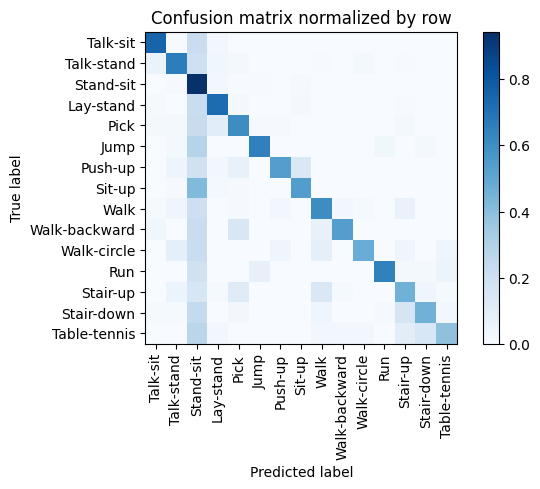

2022-09-23 15:21:46,093 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.918801307678223 seconds

2022-09-23 15:21:46,094 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.1406208872795105 seconds
2022-09-23 15:21:46,095 | INFO : Avg batch val. time: 0.142805136913477 seconds
2022-09-23 15:21:46,095 | INFO : Avg sample val. time: 0.004495330078535513 seconds
2022-09-23 15:21:46,097 | INFO : Epoch 3 Validation Summary: epoch: 3.000000 | loss: 0.031050 | accuracy: 0.663982 | precision: 0.736792 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  30%|███       | 3/10 [08:03<19:01, 163.07s/it]

Overall accuracy: 0.664

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.407      0.944      0.569      0.143        196|	 Lay-stand: 0.026,	Sit-up: 0.010,	
   Talk-stand       0.854      0.661      0.745      0.123        168|	 Stand-sit: 0.196,	Talk-sit: 0.060,	
     Talk-sit       0.878      0.753      0.811      0.119        162|	 Stand-sit: 0.216,	Lay-stand: 0.025,	
    Lay-stand       0.782      0.723      0.752      0.116        159|	 Stand-sit: 0.220,	Sit-up: 0.019,	
         Pick       0.737      0.608      0.667      0.088        120|	 Stand-sit: 0.225,	Lay-stand: 0.100,	
       Sit-up       0.817      0.538      0.649      0.067         91|	 Stand-sit: 0.418,	Lay-stand: 0.022,	
         Walk       0.716      0.608      0.658      0.058         79|	 Stand-sit: 0.203,	Stair-up: 0.063,	
     Stair-up       0.559      0.458      0.504      0.053         72|	 Stand-sit: 0.153,	Walk: 0.139,	
   Stair-down       0.744  

2022-09-23 15:24:25,985 | INFO : Epoch 4 Training Summary: epoch: 4.000000 | loss: 0.030015 | 
2022-09-23 15:24:25,987 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 39.85343050956726 seconds

2022-09-23 15:24:25,988 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 36.603275418281555 seconds
2022-09-23 15:24:25,990 | INFO : Avg batch train. time: 0.40676175433319883 seconds
2022-09-23 15:24:25,993 | INFO : Avg sample train. time: 0.012739223575879081 seconds
2022-09-23 15:24:25,994 | INFO : Evaluating on validation set ...


Evaluating Epoch 4  97.7% | batch:        42 of        43	|	loss: 0.727172

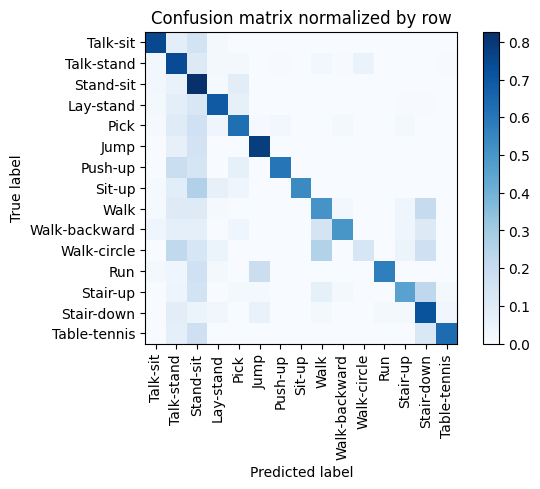

2022-09-23 15:24:31,540 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.544702053070068 seconds

2022-09-23 15:24:31,542 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 6.021437120437622 seconds
2022-09-23 15:24:31,543 | INFO : Avg batch val. time: 0.1400334214055261 seconds
2022-09-23 15:24:31,545 | INFO : Avg sample val. time: 0.00440807988319006 seconds
2022-09-23 15:24:31,549 | INFO : Epoch 4 Validation Summary: epoch: 4.000000 | loss: 0.031693 | accuracy: 0.666911 | precision: 0.715062 | 
Training Epoch:  40%|████      | 4/10 [10:48<16:24, 164.00s/it]

Overall accuracy: 0.667

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.495      0.827      0.620      0.143        196|	 Pick: 0.087,	Talk-stand: 0.056,	
   Talk-stand       0.559      0.738      0.636      0.123        168|	 Stand-sit: 0.107,	Walk-circle: 0.054,	
     Talk-sit       0.883      0.747      0.809      0.119        162|	 Stand-sit: 0.154,	Talk-stand: 0.080,	
    Lay-stand       0.827      0.692      0.753      0.116        159|	 Stand-sit: 0.126,	Talk-stand: 0.082,	
         Pick       0.658      0.625      0.641      0.088        120|	 Stand-sit: 0.167,	Talk-stand: 0.100,	
       Sit-up       1.000      0.538      0.700      0.067         91|	 Stand-sit: 0.264,	Talk-stand: 0.088,	
         Walk       0.667      0.506      0.576      0.058         79|	 Stair-down: 0.203,	Stand-sit: 0.101,	
     Stair-up       0.786      0.458      0.579      0.053         72|	 Stair-down: 0.222,	Stand-sit: 0.153,	
   Stair-d

2022-09-23 15:27:21,065 | INFO : Epoch 5 Training Summary: epoch: 5.000000 | loss: 0.029941 | 
2022-09-23 15:27:21,066 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 49.50890827178955 seconds

2022-09-23 15:27:21,068 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 39.184401988983154 seconds
2022-09-23 15:27:21,069 | INFO : Avg batch train. time: 0.41346597919216405 seconds
2022-09-23 15:27:21,071 | INFO : Avg sample train. time: 0.01294919075807233 seconds
2022-09-23 15:27:21,072 | INFO : Evaluating on validation set ...


Evaluating Epoch 5  97.7% | batch:        42 of        43	|	loss: 0.777751

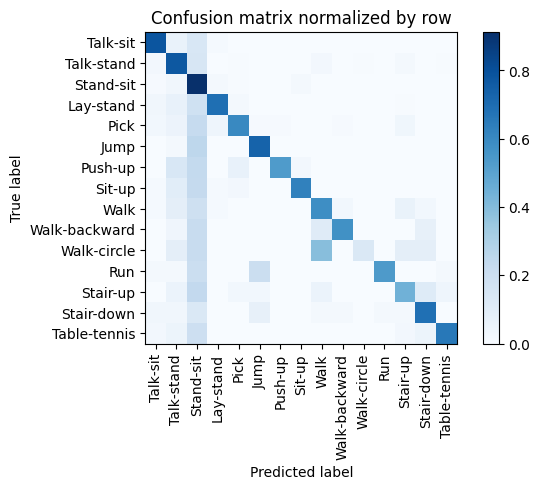

2022-09-23 15:27:26,796 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.723038673400879 seconds

2022-09-23 15:27:26,797 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 5.9717040459314985 seconds
2022-09-23 15:27:26,798 | INFO : Avg batch val. time: 0.1388768382774767 seconds
2022-09-23 15:27:26,798 | INFO : Avg sample val. time: 0.004371672068763908 seconds
2022-09-23 15:27:26,802 | INFO : Epoch 5 Validation Summary: epoch: 5.000000 | loss: 0.029947 | accuracy: 0.690337 | precision: 0.754189 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  50%|█████     | 5/10 [13:44<14:00, 168.07s/it]

Overall accuracy: 0.690

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.449      0.913      0.602      0.143        196|	 Talk-stand: 0.031,	Sit-up: 0.020,	
   Talk-stand       0.657      0.774      0.710      0.123        168|	 Stand-sit: 0.143,	Walk: 0.024,	
     Talk-sit       0.864      0.784      0.822      0.119        162|	 Stand-sit: 0.142,	Talk-stand: 0.062,	
    Lay-stand       0.894      0.692      0.780      0.116        159|	 Stand-sit: 0.182,	Talk-stand: 0.069,	
         Pick       0.857      0.600      0.706      0.088        120|	 Stand-sit: 0.225,	Talk-stand: 0.050,	
       Sit-up       0.919      0.626      0.745      0.067         91|	 Stand-sit: 0.231,	Talk-stand: 0.099,	
         Walk       0.687      0.582      0.630      0.058         79|	 Stand-sit: 0.190,	Talk-stand: 0.089,	
     Stair-up       0.653      0.444      0.529      0.053         72|	 Stand-sit: 0.236,	Stair-down: 0.111,	
   Stair-down  

2022-09-23 15:30:07,104 | INFO : Epoch 6 Training Summary: epoch: 6.000000 | loss: 0.029202 | 
2022-09-23 15:30:07,106 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 40.26446080207825 seconds

2022-09-23 15:30:07,109 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 39.36441179116568 seconds
2022-09-23 15:30:07,112 | INFO : Avg batch train. time: 0.4139335371199109 seconds
2022-09-23 15:30:07,114 | INFO : Avg sample train. time: 0.012963834034911387 seconds
2022-09-23 15:30:07,118 | INFO : Evaluating on validation set ...


Evaluating Epoch 6  97.7% | batch:        42 of        43	|	loss: 0.739739

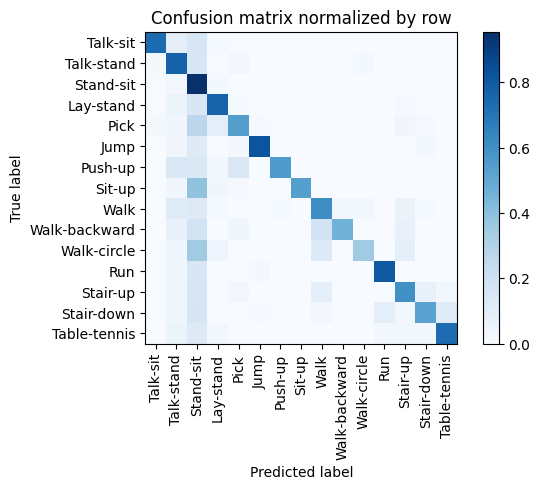

2022-09-23 15:30:12,537 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.417111396789551 seconds

2022-09-23 15:30:12,537 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 5.892476524625506 seconds
2022-09-23 15:30:12,538 | INFO : Avg batch val. time: 0.1370343377819885 seconds
2022-09-23 15:30:12,540 | INFO : Avg sample val. time: 0.00431367241919876 seconds
2022-09-23 15:30:12,543 | INFO : Epoch 6 Validation Summary: epoch: 6.000000 | loss: 0.027796 | accuracy: 0.707174 | precision: 0.769076 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  60%|██████    | 6/10 [16:29<11:09, 167.28s/it]

Overall accuracy: 0.707

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.470      0.954      0.630      0.143        196|	 Talk-stand: 0.026,	Lay-stand: 0.015,	
   Talk-stand       0.662      0.768      0.711      0.123        168|	 Stand-sit: 0.149,	Pick: 0.024,	
     Talk-sit       0.944      0.735      0.826      0.119        162|	 Stand-sit: 0.154,	Talk-stand: 0.093,	
    Lay-stand       0.836      0.767      0.800      0.116        159|	 Stand-sit: 0.145,	Talk-stand: 0.057,	
         Pick       0.783      0.542      0.640      0.088        120|	 Stand-sit: 0.267,	Lay-stand: 0.092,	
       Sit-up       1.000      0.538      0.700      0.067         91|	 Stand-sit: 0.385,	Lay-stand: 0.033,	
         Walk       0.738      0.608      0.667      0.058         79|	 Stand-sit: 0.127,	Talk-stand: 0.114,	
     Stair-up       0.694      0.597      0.642      0.053         72|	 Stand-sit: 0.153,	Walk: 0.083,	
   Stair-down       

2022-09-23 15:32:54,067 | INFO : Epoch 7 Training Summary: epoch: 7.000000 | loss: 0.028586 | 
2022-09-23 15:32:54,068 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 41.474238872528076 seconds

2022-09-23 15:32:54,069 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 39.665815659931724 seconds
2022-09-23 15:32:54,070 | INFO : Avg batch train. time: 0.41471640431151097 seconds
2022-09-23 15:32:54,071 | INFO : Avg sample train. time: 0.012988352368008762 seconds
2022-09-23 15:32:54,072 | INFO : Evaluating on validation set ...


Evaluating Epoch 7  97.7% | batch:        42 of        43	|	loss: 1.066834

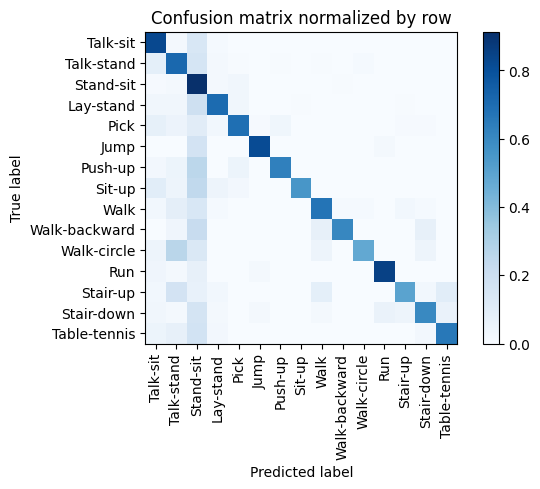

2022-09-23 15:32:59,425 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.352553129196167 seconds

2022-09-23 15:32:59,426 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 5.824986100196838 seconds
2022-09-23 15:32:59,427 | INFO : Avg batch val. time: 0.13546479302783346 seconds
2022-09-23 15:32:59,429 | INFO : Avg sample val. time: 0.004264265080671185 seconds
2022-09-23 15:32:59,432 | INFO : Epoch 7 Validation Summary: epoch: 7.000000 | loss: 0.027622 | accuracy: 0.721816 | precision: 0.770128 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  70%|███████   | 7/10 [19:16<08:21, 167.15s/it]

Overall accuracy: 0.722

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.497      0.913      0.644      0.143        196|	 Pick: 0.031,	Lay-stand: 0.020,	
   Talk-stand       0.686      0.714      0.700      0.123        168|	 Stand-sit: 0.155,	Talk-sit: 0.083,	
     Talk-sit       0.724      0.827      0.772      0.119        162|	 Stand-sit: 0.142,	Talk-stand: 0.019,	
    Lay-stand       0.842      0.704      0.767      0.116        159|	 Stand-sit: 0.189,	Pick: 0.031,	
         Pick       0.838      0.692      0.758      0.088        120|	 Stand-sit: 0.100,	Talk-sit: 0.075,	
       Sit-up       0.980      0.549      0.704      0.067         91|	 Stand-sit: 0.242,	Talk-sit: 0.099,	
         Walk       0.828      0.671      0.741      0.058         79|	 Stand-sit: 0.139,	Talk-stand: 0.089,	
     Stair-up       0.837      0.500      0.626      0.053         72|	 Talk-stand: 0.167,	Table-tennis: 0.097,	
   Stair-down       0

2022-09-23 15:35:41,618 | INFO : Epoch 8 Training Summary: epoch: 8.000000 | loss: 0.027181 | 
2022-09-23 15:35:41,621 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 42.148648500442505 seconds

2022-09-23 15:35:41,624 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 39.976169764995575 seconds
2022-09-23 15:35:41,625 | INFO : Avg batch train. time: 0.4155225188701184 seconds
2022-09-23 15:35:41,627 | INFO : Avg sample train. time: 0.01301359877694587 seconds
2022-09-23 15:35:41,629 | INFO : Evaluating on validation set ...


Evaluating Epoch 8  97.7% | batch:        42 of        43	|	loss: 1.357688

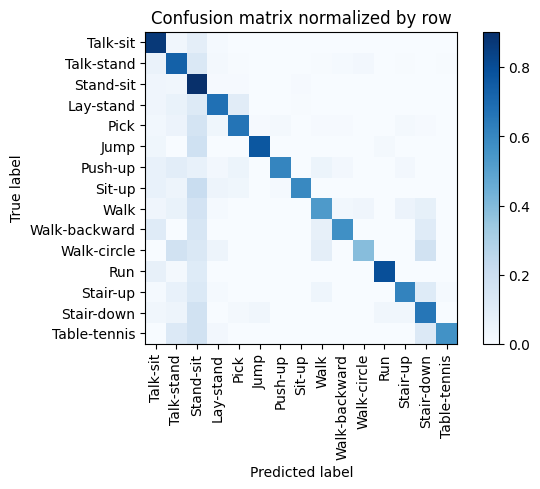

2022-09-23 15:35:47,607 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.97622537612915 seconds

2022-09-23 15:35:47,609 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 5.841790464189318 seconds
2022-09-23 15:35:47,610 | INFO : Avg batch val. time: 0.13585559219044924 seconds
2022-09-23 15:35:47,611 | INFO : Avg sample val. time: 0.004276566957678856 seconds
2022-09-23 15:35:47,615 | INFO : Epoch 8 Validation Summary: epoch: 8.000000 | loss: 0.027806 | accuracy: 0.715959 | precision: 0.754212 | 
Training Epoch:  80%|████████  | 8/10 [22:04<05:34, 167.47s/it]

Overall accuracy: 0.716

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.525      0.903      0.664      0.143        196|	 Talk-sit: 0.036,	Talk-stand: 0.031,	
   Talk-stand       0.680      0.732      0.705      0.123        168|	 Stand-sit: 0.131,	Talk-sit: 0.060,	
     Talk-sit       0.738      0.870      0.799      0.119        162|	 Stand-sit: 0.086,	Talk-stand: 0.031,	
    Lay-stand       0.844      0.679      0.753      0.116        159|	 Stand-sit: 0.113,	Pick: 0.101,	
         Pick       0.762      0.667      0.711      0.088        120|	 Stand-sit: 0.158,	Talk-stand: 0.050,	
       Sit-up       0.947      0.593      0.730      0.067         91|	 Stand-sit: 0.209,	Talk-sit: 0.066,	
         Walk       0.792      0.532      0.636      0.058         79|	 Stand-sit: 0.165,	Stair-down: 0.076,	
     Stair-up       0.815      0.611      0.698      0.053         72|	 Stand-sit: 0.125,	Stair-down: 0.111,	
   Stair-down    

2022-09-23 15:38:31,319 | INFO : Epoch 9 Training Summary: epoch: 9.000000 | loss: 0.027811 | 
2022-09-23 15:38:31,320 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 43.69709610939026 seconds

2022-09-23 15:38:31,322 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 40.389606025483886 seconds
2022-09-23 15:38:31,323 | INFO : Avg batch train. time: 0.41659637928697113 seconds
2022-09-23 15:38:31,325 | INFO : Avg sample train. time: 0.013047230621124534 seconds
2022-09-23 15:38:31,325 | INFO : Evaluating on validation set ...


Evaluating Epoch 9  97.7% | batch:        42 of        43	|	loss: 0.558579

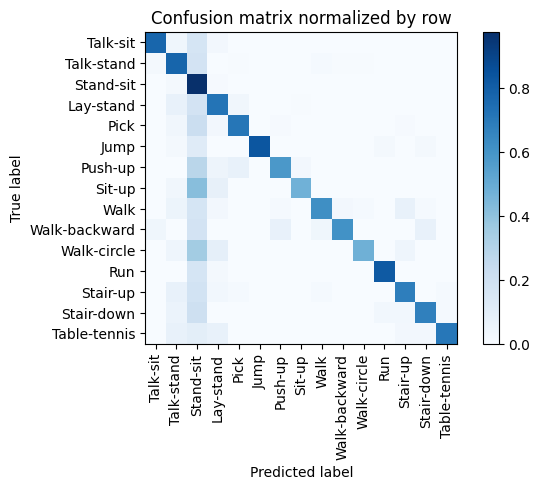

2022-09-23 15:38:36,642 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.316204071044922 seconds

2022-09-23 15:38:36,644 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 5.789231824874878 seconds
2022-09-23 15:38:36,645 | INFO : Avg batch val. time: 0.13463329825290413 seconds
2022-09-23 15:38:36,646 | INFO : Avg sample val. time: 0.0042380906477854155 seconds
2022-09-23 15:38:36,647 | INFO : Epoch 9 Validation Summary: epoch: 9.000000 | loss: 0.025271 | accuracy: 0.738653 | precision: 0.817115 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
Training Epoch:  90%|█████████ | 9/10 [24:53<02:47, 167.97s/it]

Overall accuracy: 0.739

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.449      0.974      0.615      0.143        196|	 Talk-stand: 0.015,	Lay-stand: 0.010,	
   Talk-stand       0.743      0.774      0.758      0.123        168|	 Stand-sit: 0.179,	Talk-sit: 0.018,	
     Talk-sit       0.969      0.772      0.859      0.119        162|	 Stand-sit: 0.167,	Talk-stand: 0.037,	
    Lay-stand       0.803      0.717      0.757      0.116        159|	 Stand-sit: 0.176,	Talk-stand: 0.069,	
         Pick       0.895      0.708      0.791      0.088        120|	 Stand-sit: 0.217,	Talk-stand: 0.033,	
       Sit-up       0.956      0.473      0.632      0.067         91|	 Stand-sit: 0.418,	Lay-stand: 0.077,	
         Walk       0.925      0.620      0.742      0.058         79|	 Stand-sit: 0.165,	Stair-up: 0.076,	
     Stair-up       0.817      0.681      0.742      0.053         72|	 Stand-sit: 0.181,	Talk-stand: 0.069,	
   Stair-do

2022-09-23 15:41:18,542 | INFO : Epoch 10 Training Summary: epoch: 10.000000 | loss: 0.027025 | 
2022-09-23 15:41:18,543 | INFO : Epoch runtime: 0.0 hours, 2.0 minutes, 41.8607759475708 seconds

2022-09-23 15:41:18,544 | INFO : Avg epoch train. time: 0.0 hours, 2.0 minutes, 40.536723017692566 seconds
2022-09-23 15:41:18,544 | INFO : Avg batch train. time: 0.416978501344656 seconds
2022-09-23 15:41:18,546 | INFO : Avg sample train. time: 0.013059198162994596 seconds
2022-09-23 15:41:18,546 | INFO : Evaluating on validation set ...


Evaluating Epoch 10  97.7% | batch:        42 of        43	|	loss: 0.799596

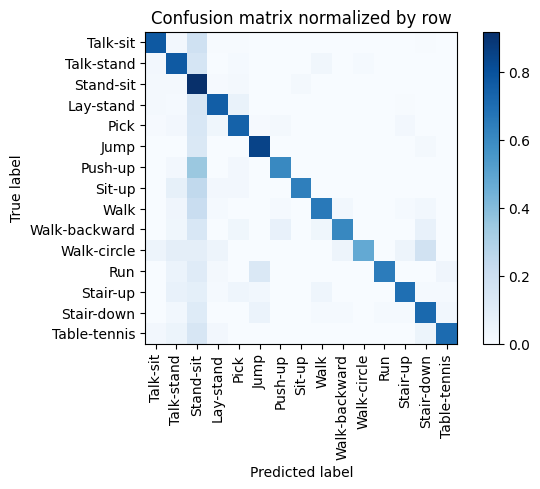

2022-09-23 15:41:24,108 | INFO : Validation runtime: 0.0 hours, 0.0 minutes, 5.561089515686035 seconds

2022-09-23 15:41:24,110 | INFO : Avg val. time: 0.0 hours, 0.0 minutes, 5.768491614948619 seconds
2022-09-23 15:41:24,111 | INFO : Avg batch val. time: 0.13415096778950278 seconds
2022-09-23 15:41:24,111 | INFO : Avg sample val. time: 0.004222907478000453 seconds
2022-09-23 15:41:24,113 | INFO : Epoch 10 Validation Summary: epoch: 10.000000 | loss: 0.024725 | accuracy: 0.748170 | precision: 0.798970 | 
c:\Users\deela\anaconda3\envs\mvts_trans\lib\site-packages\numpy\lib\npyio.py:696: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  val = np.asanyarray(val)
2022-09-23 15:41:24,162 | INFO : Best loss was 0.02472457900577897. Other metrics: OrderedDict([('epoch', 10), ('l

Overall accuracy: 0.748

                precision     recall   f1-score rel. freq. abs. freq.|	 biggest thieves

    Stand-sit       0.486      0.918      0.636      0.143        196|	 Sit-up: 0.020,	Talk-sit: 0.020,	
   Talk-stand       0.772      0.768      0.770      0.123        168|	 Stand-sit: 0.155,	Walk: 0.030,	
     Talk-sit       0.899      0.772      0.831      0.119        162|	 Stand-sit: 0.185,	Talk-stand: 0.025,	
    Lay-stand       0.896      0.755      0.819      0.116        159|	 Stand-sit: 0.145,	Pick: 0.063,	
         Pick       0.795      0.742      0.767      0.088        120|	 Stand-sit: 0.142,	Lay-stand: 0.033,	
       Sit-up       0.935      0.637      0.758      0.067         91|	 Stand-sit: 0.242,	Talk-stand: 0.077,	
         Walk       0.839      0.658      0.738      0.058         79|	 Stand-sit: 0.215,	Talk-stand: 0.038,	
     Stair-up       0.877      0.694      0.775      0.053         72|	 Stand-sit: 0.083,	Talk-stand: 0.069,	
   Stair-down       0.79

In [14]:
# Evaluate on validation before training
aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config, best_metrics,
                                                        best_value, epoch=0, class_names=config['class_names'])
metrics_names, metrics_values = zip(*aggr_metrics_val.items())
metrics.append(list(metrics_values))

logger.info('Starting training...')
for epoch in tqdm(range(start_epoch + 1, config["epochs"] + 1), desc='Training Epoch', leave=False):
    mark = epoch if config['save_all'] else 'last'
    epoch_start_time = time.time()
    aggr_metrics_train = trainer.train_epoch(epoch)  # dictionary of aggregate epoch metrics
    # print(f"train metrics >> {aggr_metrics_train}")
    run['train/loss'].log(aggr_metrics_train['loss'])
    epoch_runtime = time.time() - epoch_start_time
    print_str = 'Epoch {} Training Summary: '.format(epoch)
    for k, v in aggr_metrics_train.items():
        tensorboard_writer.add_scalar('{}/train'.format(k), v, epoch)
        print_str += '{}: {:8f} | '.format(k, v)
    logger.info(print_str)
    logger.info("Epoch runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(epoch_runtime)))
    total_epoch_time += epoch_runtime
    avg_epoch_time = total_epoch_time / (epoch - start_epoch)
    avg_batch_time = avg_epoch_time / len(train_loader)
    avg_sample_time = avg_epoch_time / len(train_dataset)
    logger.info("Avg epoch train. time: {} hours, {} minutes, {} seconds".format(*utils.readable_time(avg_epoch_time)))
    logger.info("Avg batch train. time: {} seconds".format(avg_batch_time))
    logger.info("Avg sample train. time: {} seconds".format(avg_sample_time))

    # evaluate if first or last epoch or at specified interval
    if (epoch == config["epochs"]) or (epoch == start_epoch + 1) or (epoch % config['val_interval'] == 0):
        aggr_metrics_val, best_metrics, best_value = validate(val_evaluator, tensorboard_writer, config,
                                                                best_metrics, best_value, epoch, config['class_names'])
        # print(f"eval metrics >> {aggr_metrics_val}")
        run['eval/loss'].log(aggr_metrics_val['loss'])
        run['eval/accuracy'].log(aggr_metrics_val['accuracy'])
        run['eval/precision'].log(aggr_metrics_val['precision'])
        metrics_names, metrics_values = zip(*aggr_metrics_val.items())
        metrics.append(list(metrics_values))

    # utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(mark)), epoch, model, optimizer)

    # Learning rate scheduling
    if epoch == config['lr_step'][lr_step]:
        utils.save_model(os.path.join(config['save_dir'], 'model_{}.pth'.format(epoch)), epoch, model, optimizer)
        lr = lr * config['lr_factor'][lr_step]
        if lr_step < len(config['lr_step']) - 1:  # so that this index does not get out of bounds
            lr_step += 1
        logger.info('Learning rate updated to: ', lr)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    # Difficulty scheduling
    if config['harden'] and check_progress(epoch):
        train_loader.dataset.update()
        val_loader.dataset.update()

# Export evolution of metrics over epochs
# header = metrics_names #@nipdep
# metrics_filepath = os.path.join(config["output_dir"], "metrics_" + config["experiment_name"] + ".xls")
# book = utils.export_performance_metrics(metrics_filepath, metrics, header, sheet_name="metrics")

# # Export record metrics to a file accumulating records from all experiments
# utils.register_record(config["records_file"], config["initial_timestamp"], config["experiment_name"],
#                         best_metrics, aggr_metrics_val, comment=config['comment'])

logger.info('Best {} was {}. Other metrics: {}'.format(config['key_metric'], best_value, best_metrics))
logger.info('All Done!')

total_runtime = time.time() - total_start_time
logger.info("Total runtime: {} hours, {} minutes, {} seconds\n".format(*utils.readable_time(total_runtime)))

run.stop()

In [15]:
model.train()
for i in val_loader:
    x, y, m, ids = i
    x = x.to(device)
    m = m.to(device)
    pred = model(x, m)
    break

In [16]:
pred.shape

torch.Size([32, 15])

In [17]:
probs = torch.softmax(pred, dim=-1)
pred_label = torch.argmax(probs, dim=-1)
pred_label.shape

torch.Size([32])

In [18]:
pred_label

tensor([ 8,  3,  2,  2,  2,  1,  0,  0,  1,  2,  8,  2,  3, 14,  9, 13,  1,  3,
        13,  2,  4,  5,  4, 11,  4,  4,  6,  8,  1,  4,  3,  0],
       device='cuda:0')

In [19]:
y

tensor([ 8,  3,  4,  2,  2,  1,  0,  0,  1, 12,  8,  2,  3, 14,  9, 13,  1,  3,
        13,  2,  4,  5,  4, 11,  4,  4,  6,  8,  1,  4,  3,  0])

In [20]:
model.transformer_encoder.layers[0].linear1.weight.grad

tensor([[-0.0009,  0.0226,  0.0126,  ..., -0.0002,  0.0213, -0.0041],
        [ 0.0034,  0.0016,  0.0030,  ...,  0.0025,  0.0146, -0.0249],
        [ 0.0024, -0.0049, -0.0054,  ...,  0.0127, -0.0061, -0.0070],
        ...,
        [-0.0033,  0.0009, -0.0059,  ...,  0.0017,  0.0057, -0.0026],
        [-0.0224, -0.0104, -0.0260,  ..., -0.0132,  0.0042, -0.0137],
        [-0.0091, -0.0093, -0.0109,  ..., -0.0011,  0.0072, -0.0079]],
       device='cuda:0')

In [21]:
model

TSTransformerEncoderClassiregressor(
  (project_inp): Linear(in_features=6, out_features=128, bias=True)
  (pos_enc): LearnablePositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerBatchNormEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (norm2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerBatchNormEncoderLa

In [5]:
# test 1D-Conv layer
import torch
from torch import nn
import torch.nn.functional as F

In [23]:
conv_layer = nn.Conv1d(300, 1, 1)
sample_inp = torch.rand((32, 300, 128))
sample_out = conv_layer(sample_inp)
sample_out.shape

torch.Size([32, 1, 128])

In [6]:
class VariationalEncoder(nn.Module):
    def __init__(self, latent_dims):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(784, 512)
        self.linear2 = nn.Linear(512, latent_dims)
        self.linear3 = nn.Linear(512, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
        self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        return z

In [7]:
varc_layer = VariationalEncoder(64)
sample_input = torch.rand((32, 300, 128))
sample_output = varc_layer(sample_input)
sample_output.shape

RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x38400 and 784x512)